The goal here is to calculate the zero-temperature Parisi constant for a pure p-spin glass.

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the paper above:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from scipy import stats

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [2]:
global k, xi, xiprime, xiprimeprime

In [3]:
def a(qs, l):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [4]:
def psi(qs, ms, l):
    offset = lambda x, z: psi(qs, ms, l+1)(x + a(qs, l)*z)
    if l == k+1:
        return lambda x: abs(x)
    elif l == 0:
        return Expectation(offset)
    else:
        return lambda v: 1/ms[l] * np.log(Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v))

This defines the expectation value.

In [5]:
INPS = np.linspace(-20,20, 40001)
PDF_INPS = stats.norm.pdf(INPS)/1000
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)

In [6]:
def Expectation(f):
    # f is function of x and z, where z is gaussian
    return lambda x: np.sum(f(x,INPS)*PDF_INPS)

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [7]:
def penalty(qs, ms):
    out = 0
    for i in range(k+1):
        out += ms[i] * integrate.quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [8]:
# the input here is a list of "adjustments" 
# (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
def test(inp):
    assert len(inp) == 2*k
    inp_qs,inp_ms= inp[:k],inp[k:]

    # if bad input, return a large number
    if np.any(np.array(inp) < 0) or sum(inp_ms) > 1 or sum(inp_qs) > 1:
        return 10000

    qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
    ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
    return psi(qs, ms, 0)(0) - penalty(qs, ms)

p: 2 1.08729840033861
qs: [0.00000000e+00 2.65421356e-12 5.05799731e-12 6.16619355e-12
 1.30675105e-11]
ms: [0.         0.25761341 0.36120447 0.45287636 0.57786275]
p: 3 1.1505121652408838
qs: [0.00000000e+00 2.01388132e-12 5.82777881e-12 7.81244644e-12
 9.91865513e-12]
ms: [0.         0.90805843 0.93678573 0.95131484 0.97832738]
p: 4 1.1701342620230228
qs: [0.00000000e+00 7.02297802e-12 1.32523059e-11 2.02071832e-11
 2.81531745e-11]
ms: [0.         0.64903334 0.81003895 0.82111067 1.        ]
p: 5 1.1803925191499216
qs: [0.00000000e+00 3.63155129e-10 4.45904720e-09 6.90944443e-09
 9.76068083e-09]
ms: [0.         0.66436243 0.89367166 0.90432909 1.        ]
p: 6 1.1859685323386193
qs: [0.00000000e+00 9.54623655e-09 1.56949630e-08 3.11495209e-08
 3.12136698e-07]
ms: [0.         0.72661265 0.80624242 0.86046962 1.        ]
p: 7 1.1890633646707425
qs: [0.00000000e+00 2.36444476e-07 7.82625984e-07 2.10475380e-06
 5.49678913e-06]
ms: [0.         0.74904299 0.98324689 0.98499042 1.        ]


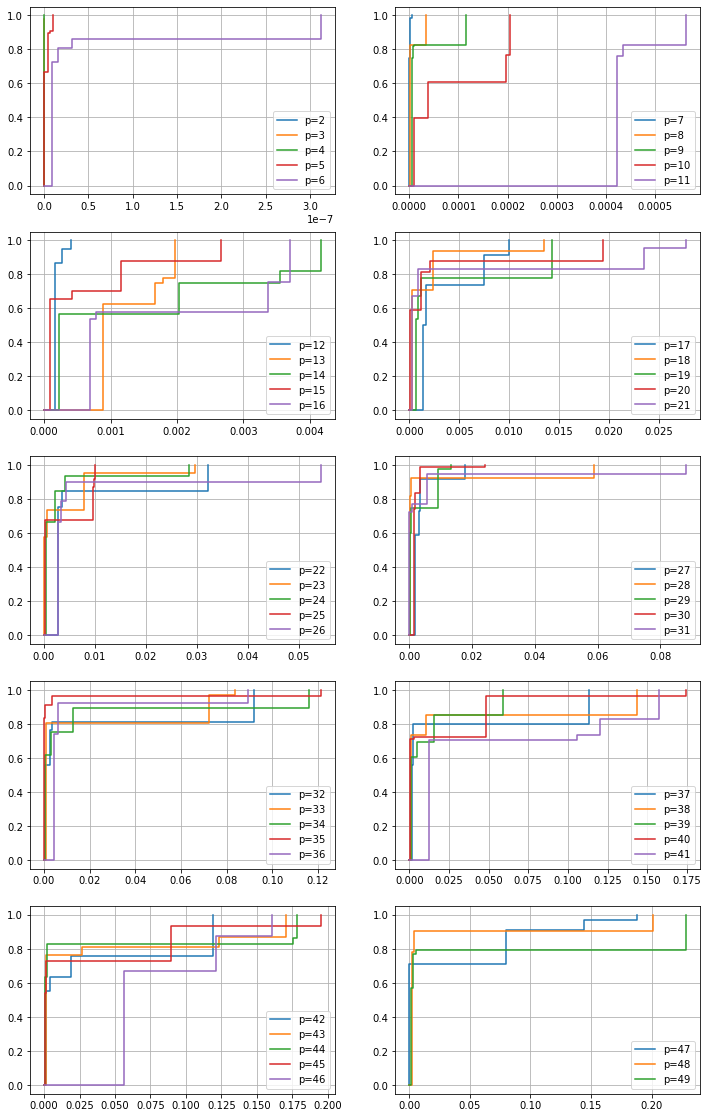

In [9]:
%%time

# pure p-spin model; p=2 is SK model
ps = range(2, 50)
# number of jumps
k=4

num_vertical_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vertical_plots, 2, figsize=(12, 4*num_vertical_plots))
outs = []
for idx in range(len(ps)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: x**P
    xiprime = lambda x: P * (x**(P-1))
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2))
    
    # find best function from minimizer
    best = None
    for _ in range(5):
        opt = minimize(test, [np.random.random()/k for _ in range(2*k)], method='Powell', options={"ftol":1e-14})
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
    print("qs:", qs)
    print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://sci-hubtw.hkvisa.net/10.1002/cpa.21886

These are the values of the constants:

In [10]:
for p, x in zip(ps, outs):
    print(p, x)

2 1.08729840033861
3 1.1505121652408838
4 1.1701342620230228
5 1.1803925191499216
6 1.1859685323386193
7 1.1890633646707425
8 1.1908055719209436
9 1.1917963694858242
10 1.192364172251569
11 1.192691516871884
12 1.1928811421370593
13 1.1929914227617324
14 1.193055770952327
15 1.193093423455509
16 1.193115508771963
17 1.1931284904484905
18 1.193136135233475
19 1.1931406446052488
20 1.1931433084375147
21 1.1931448841365988
22 1.1931458173042149
23 1.1931463705510357
24 1.1931466988804011
25 1.1931468939077696
26 1.1931470098508399
27 1.193147078832018
28 1.193147119902127
29 1.1931471443706663
30 1.193147158957565
31 1.1931471676585375
32 1.1931471728518463
33 1.1931471759523191
34 1.1931471778045868
35 1.1931471789118326
36 1.1931471795733515
37 1.1931471799693583
38 1.1931471802062035
39 1.193147180348106
40 1.193147180432966
41 1.1931471804839546
42 1.1931471805143588
43 1.1931471805325273
44 1.193147180543722
45 1.193147180550035
46 1.1931471805550302
47 1.1931471805566218
48 1.193147

The numbers seem to converge -- is there an asymptotic value for large $p$? Perhaps $0.5 + ln(2) \approx 1.19314718055994$?


In [11]:
np.log(2) + 0.5

1.1931471805599454

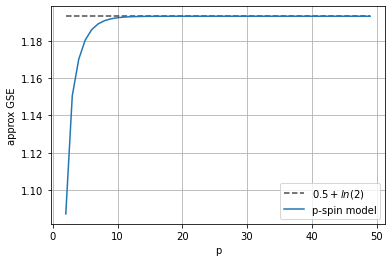

In [12]:
plt.plot(ps, [np.log(2) + 0.5]*len(ps), 'b--', color='black', label="$0.5+ln(2)$", alpha=0.7)
plt.plot(ps, outs, label="p-spin model")
plt.xlabel("p")
plt.ylabel("approx GSE")
plt.grid()
plt.legend()

I insert these values for Subrabhata Sen's bounds for MAX XOR on hypergraphs, as listed here: https://sci-hubtw.hkvisa.net/10.1002/rsa.20774

The satisfying fraction for MAX CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [13]:
for p, x in zip(ps, outs):
    print(p, x*p**0.5 / 2)

2 0.7688360720527166
3 0.9963727624616452
4 1.1701342620230228
5 1.3197189564757235
6 1.4525088776135338
7 1.5729829780082452
8 1.6840533899600487
9 1.7876945542287364
10 1.8852932923481491
11 1.977855126051938
12 2.066130745572178
13 2.1506958729780816
14 2.232002969108527
15 2.31041547975639
16 2.386231017543926
17 2.459697395526439
18 2.5310239563068992
19 2.600389747632629
20 2.6679495445652814
21 2.7338383733026395
22 2.798174972625548
23 2.8610644879074076
24 2.9226006005431517
25 2.982867234769424
26 3.0419399429071574
27 3.0998870421591658
28 3.156770556773993
29 3.2126470057989716
30 3.2675680669213025
31 3.321581139850391
32 3.3747298275083937
33 3.4270543493990147
34 3.4785918986244893
35 3.529376951711317
36 3.5794415387200544
37 3.6288154797242993
38 3.6775265926330345
39 3.7256008765343074
40 3.7730626739760593
41 3.8199348150907375
42 3.8662387459749974
43 3.9119946433931543
44 3.957221517533958
45 4.00193730430814
46 4.04615894847988
47 4.08990247866927
48 4.13318307526

The agreement $C_2 \approx P_* \approx 0.76$ gives me confidence that this approach is correct.

What do you think?